# Machine Learning in Python - Group Project 2

**Due Friday, April 14th by 16.00 pm.**

*William Jones, Tristan Pang, Aidan Garrity, Elliot
Leishman* 

(Group 15)

# Head of state's message: 

I think we have established that logistic regression is not great but we may want to include this analysis anyway. Also do we want to consider cross validation again ? 

<span style="color: red;"> THE JOB BOARD: </span> 

    - Myself: Look into using Neural Nets, probably with heavy use of chat gpt, maybe Tensor Flow but I think its doable with pipelines
    - Aidan: Continue the good work on decision trees chief
    - Tristan: Work on support vector machines, if you're feeling brave 
    - Squire Boy: Look at stratifying the data, probably by hotel type and maybe month ? Also continue the good work on data exploration !

Also, comment code, please

# Supreme Leader of the Ministry of Theory's Message

Classification task

Obviously we want a model with a low FPR and FNR. But we care most about lowering FPR, since having a room double booked is worse then having a room booking cancelled. Double bookings could result in financial losses, bad reviews and lawsuits, I guess?

4 most obvious classification strategies:
 - Logistic Regression
 - Support Vector Machines
 - Decision Trees
 - Neural Networks

Do we want to stratify our test-train split for resort and city hotel?

Ways to compare classification models:
 - Confusion Matrices
 - ROC curves & AUC
 - Accuracy
 - F1 score
 - Precision is the most important part

## General Setup

In [32]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# sklearn modules
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# For country heatmap
import folium
from folium.plugins import HeatMap
import plotly.express as px


In [33]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

In [34]:
# Load data
d = pd.read_csv("hotel.csv")

In [35]:
def proportion_table(df, feat, index, show = True):
    '''
    Creates a proportion table for a feature in dataframe. Takes
    a dataframe `df`, and a feature column `feat` and index row.
    Returns proportion table (prints if show=True).
    '''

    # Create proportion table of entire feature
    prop_table = pd.DataFrame(df[feat].value_counts()).reset_index()
    prop_table = prop_table.rename(columns= {feat:'Total', 'index':index})

    for i in [0,1]: # Denotes if we are considering cancelation or not
        if i == 0:
            cancel_status = 'Not_canceled'
        else:
            cancel_status = 'Canceled'
        df_canc = df[(df['is_canceled'] == i)]
        df_canc = pd.DataFrame(df_canc[feat].value_counts()).reset_index()
        df_canc = df_canc.rename(columns= {feat:cancel_status, 'index':index})
        prop_table = prop_table.merge(df_canc, on = index, how = 'outer')

        # Calculate propoprtions
        prop_table[f'% {cancel_status}'] = prop_table[cancel_status] / prop_table['Total'] * 100


    # Round proportions to two decimal places
    prop_table = prop_table.round(2)

    # Display DataFrame or return it
    if show:
        display(prop_table)
    else:
        return(prop_table)

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.


THINGS WE SHOULD INCLUDE IN OUR INTRODUCTION:
- Theory about the models we use
- Theory about the metrics we will use in model evaluation.
- General discussion of the dataset
- Feature transformation - or lack thereof

In [36]:
display(d)

print(d.columns)

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,Resort Hotel,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0
1,0,Resort Hotel,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0
2,0,Resort Hotel,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0
3,0,Resort Hotel,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0
4,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,City Hotel,23,2017,August,35,30,2,5,2,...,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0
119386,0,City Hotel,102,2017,August,35,31,2,5,3,...,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2
119387,0,City Hotel,34,2017,August,35,31,2,5,2,...,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4
119388,0,City Hotel,109,2017,August,35,31,2,5,2,...,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0


Index(['is_canceled', 'hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')


---
## **2. Exploratory Data Analysis and Feature Engineering**

This section is split into 6 sections, they are:
- Initial data cleaning
- Collection errors
- Response variable
- Feature investigation
- Data encoding
- Correlation

Note section 2.4 (Feature investigation is split up into further subsection to increase readability).

### **2.1 Initial data cleaning**

In this section we will perform basic cleaning of the data. In particular, we will:
- Deal with na values.
- Check for duplicate values.
- Examine the structure, shape and type of data features.
- Encode categorical variables with numerical values.

$\newline$
We start by examining any null values that exist in the dataframe. 

In [37]:
# Copy original dataframe
df = d.copy()

# Get columns which have NaN values 
cols_with_nan = d.columns[d.isna().any()].tolist()
print('Features containing NaN values are: ', cols_with_nan)

# Find out how many NaN values are in those columns
for col in cols_with_nan:

    # Count number of na values
    no_nas = d[col].isna().sum()
    # Calculate the percentage of total values which are nas
    perc_vals_na = 100 * no_nas /119390
    # Print 
    print(f"Column '{col}' contains {no_nas} NaN values, this constitutes {np.round(perc_vals_na,2)}% of values.")

Features containing NaN values are:  ['children', 'country', 'agent', 'company']
Column 'children' contains 4 NaN values, this constitutes 0.0% of values.
Column 'country' contains 488 NaN values, this constitutes 0.41% of values.
Column 'agent' contains 16340 NaN values, this constitutes 13.69% of values.
Column 'company' contains 112593 NaN values, this constitutes 94.31% of values.


From the code segment above we can see that the children and country features have 4 and 488 NaN values. Because these observations represent such a small percentage (<0.5%) of our total observations we drop the entire observation from the dataframe rather then attempt to impute a value for them. For the agent feature we assume these values correspond to zero i.e. no agent was used in the booking process, therefore impute these with a zero. We make this assumption because there are no observations with no agent in the raw data. For the company feature we remove the entire feature from our dataset because it contains 94% NaN values.

Furthermore, we drop duplicate observations here. We can do this with confidence because it is very unlikely that two parties will have booked the exact same stay in the exact same hotel on the exact same day. We do however acknowledge that although unlikely, this is still possible, but we are assuming that the true duplicates make up a negligable proportion of the total duplicates.

We implement these changes and next consider the datatypes in our dataframe.

In [38]:
# drop rows which have NaN values in 'children' columns. 
df = df.dropna(subset=['children', 'country'])

df = df.drop('company', axis = 1)

# fill the remaining NaN values to be zero
df = df.fillna(0)

# Delete duplicate rows. Note 32215 rows are duplicated rows to delete
df.drop_duplicates(keep='first', inplace=True)

In [39]:
# Investigating shape and datatypes of dataframe
print(f'The dataframe is of size {df.shape}')
print(df.dtypes)

The dataframe is of size (86675, 29)
is_canceled                         int64
hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       obje

We observe that the dataframe has 29 features and 119390 observations. Due to overfitting and cost issues some models may be impractical to use with such a large dataset so we will have to consider the size of the dataframe when selecting a model. We may choose to only use a sample of this dataset. 

16 features are of datatype int, 4 are floats and 10 are object. These datatypes are indeed suitable for the features we have.  For example, integer types are counting number of occurances and hence it makes sense to store these are integers. 

For the float features we: 
- Convert the 'children' feature into an integer because we cannot have a non-whole number of children.
- Rename 'adr' as 'avg_daily_rate' as this more clearly conveys what it means. We keep this feature as a float because it corresponds to a price and will need to store values after the decimal point. 
- Re-encode 'agent'  as binary integer features. This column has a number encoding the travel agent the hotel was booked through but we do not have access to this encoding. Therefore, we would not be able to reccommend a specific agent to the clients. We will instead investigate whether booking through an agent affects cancellation as opposed to investigating which agents affect cancellations. 

Note: For the object features, we will later need to encode them with numerical values before fitting our model.

In [40]:
# Convert children column to integer
df['children'] = df['children'].astype('int64')

# Rename the adr column
df = df.rename(columns={"adr": "avg_daily_rate"})

# Encode agent as binary 1 = yes, 0 = no
agent_used = (df.agent != 0)
df.loc[agent_used, 'agent'] = 1

# Change datatype to integer
df['agent'] = df['agent'].astype('int64')

### **2.2 Collection errors**

As we have considered NaN values and duplicates we can now consider observations in our data set that do not make sense. In particular we will look at the following three scenarios:

- A room has been booked but the number of adults, children and babies staying in that booking is zero.
- A room was stayed in for zero weekday nights and zero weekend nights.
- A customer is marked as a repeat customer but has no previous stays or cancelations recorded.

Any observation which falls into one of these three categories will be removed at this stage.

In [41]:
# No adults, children or babies
no_people = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
print(f'Number of observations with no people is {df[no_people].shape[0]}')

# No weekend or weekday nights were spent at hotel
no_nights = (df.stays_in_weekend_nights == 0) & (df.stays_in_week_nights == 0)
print(f'Number of observations with no nights is {df[no_nights].shape[0]}')

# Repeat customer with no previous stays recorded
no_prev_stays = (df.is_repeated_guest == 1) & (df.previous_cancellations == 0) & (df.previous_bookings_not_canceled == 0)
print(f'Number of observations with incorrect previous stays is {df[no_prev_stays].shape[0]}')

# Delete these anomolous observations from the dataframe
bool_series = no_people|no_nights|no_prev_stays
df = df[~bool_series.reindex(df.index)]

print(f'Number of removed observations is {df[bool_series.reindex(df.index)].shape[0]}')

Number of observations with no people is 161
Number of observations with no nights is 642
Number of observations with incorrect previous stays is 506
Number of removed observations is 0


We have removed 913 observations from the dataset because they did not make logical sense. The most common collection error was not recording anyone to stay in the rooms.

### **2.3 Response variable**
In this section we will examine the response variable 'is_canceled'. We examine the balance and distribution of the classes as this will inform us on our model choice.

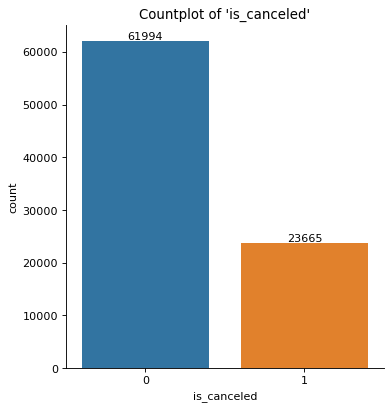

In [42]:
sns.catplot(data = df, x = 'is_canceled', kind  = 'count')

# Print the counts on each bar 
ax = plt.gca()  # Get the current axes
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Labels
                (p.get_x() + p.get_width() / 2, p.get_height()),  # The x, y coordinates of the text
                ha='center', va='bottom')  # Horizontal and vertical alignment of the text
    
plt.title("Countplot of 'is_canceled'")
plt.show()

The above plot shows that the ratio of not cancelled to cancelled is approximately 3:1. Therefore, the data response variable does not exhibit a large class imbalance and we do not to be too careful when constructing our models. To increase the accuracy of the model we will conduct stratified sampling of the response variable when we doing the test-train split. 

### **2.4 Feature Investigation**
We will know examine each remaining feature of the dataset. We will consider seperately the continuous features and the categorical features. For each we suitably visualise the data, examine summary statistics and use our knowledge of the context to establish possible outliers. When considering categorical variables we will further split them up into four groups: date & time, personal information, booking information and other information.

#### **2.4.1 Continuous Variables**

The continuous features in our dataset are: 'avg_daily_rate' and 'lead_time'. We investigate these seperately.

***'avg_daily_rate':***

In [43]:
# Print summary statistics for avg_daily_rate
print(df['avg_daily_rate'].describe())

count    85659.000000
mean       107.554604
std         54.334081
min         -6.380000
25%         73.460000
50%         99.000000
75%        135.000000
max       5400.000000
Name: avg_daily_rate, dtype: float64


On review of the summary statistics we can see that the minimum value is negative - this makes no sense as it implies the hotel is paying someone to stay there. To counter this we will remove all observations that have a negative 'avg_daily_rate'. Another consideration is that the max value is 5400 - this is 98 standard deviations away from the mean so we will consider it an outlier and remove it. 

Number of observations with negative adr is 1
Number of outliers with value 5400 is 1


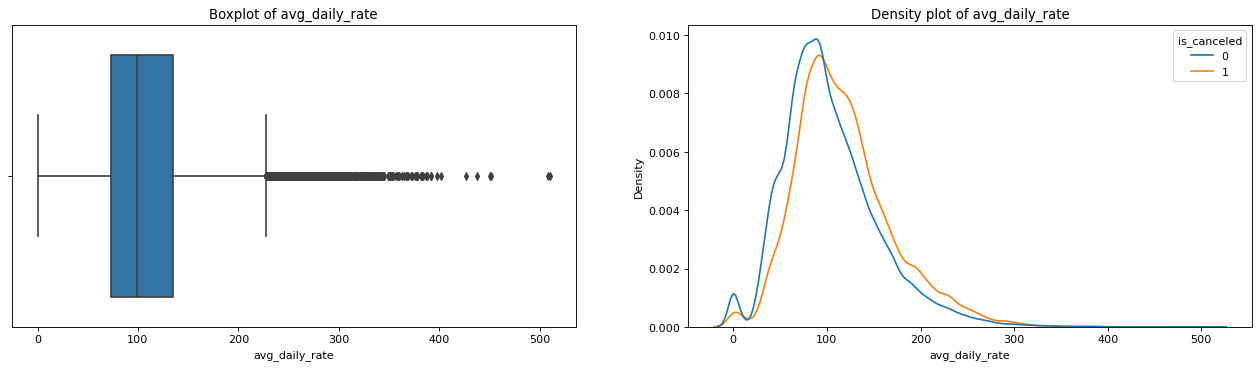

In [44]:
# Remove observations with negative average daily rate
neg_adr = (df.avg_daily_rate < 0)
print(f'Number of observations with negative adr is {df[neg_adr].shape[0]}')
df = df[~neg_adr]

# Remove outlier
outlier = (df.avg_daily_rate == 5400)
print(f'Number of outliers with value 5400 is {df[outlier].shape[0]}')
df = df[~outlier]

fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (20,5))
# Boxplot with outlier
sns.boxplot(data = df, x = 'avg_daily_rate', ax = axes[0])
axes[0].set_title('Boxplot of avg_daily_rate')

# Density plot - common_norm = False, sets each curve to have density 1
sns.kdeplot(data = df, x = 'avg_daily_rate', hue = 'is_canceled', common_norm = False, ax = axes[1])
axes[1].set_title('Density plot of avg_daily_rate')
plt.show()

By examining the boxplot we see that the value of 5400 was an outlier, which varifies our decision to remove it. We see that there are some values close to zero, intuitively these are hard to explain in context, but they could be due to the customer recieving a large discount. If we look at the density plot we can see that these values very close to zero don't make up a large proportion of the observations so we will leave them in our dataset. The density plot also shows us that the distribution of daily average rate is roughly the same for cancelled bookings and non-cancelled bookings, therefore, we wouldn't expect avg_daily_rate to have a large impact on cancellations.

***'lead_time':***

In [45]:
# Print summary statistics for avg_daily_rate - can i also display for canceled/no_canceled?
print(df['lead_time'].describe())

count    85657.000000
mean        80.624619
std         86.025402
min          0.000000
25%         12.000000
50%         50.000000
75%        126.000000
max        709.000000
Name: lead_time, dtype: float64


This summary statistics of 'lead_time' does not indicate any immediate outliers, so we examine the boxplot further. 

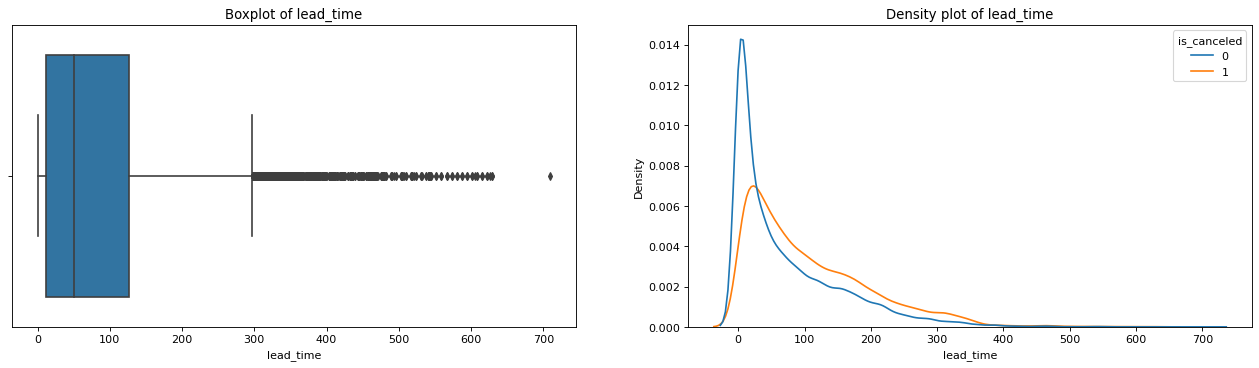

In [46]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (20,5))

# Boxplot
sns.boxplot(data = df, x = 'lead_time', ax = axes[0])
axes[0].set_title('Boxplot of lead_time')

# Density plot - common_norm = False, sets each curve to have density 1
sns.kdeplot(data = df, x = 'lead_time', hue = 'is_canceled', common_norm= False, ax = axes[1])
axes[1].set_title('Density plot of lead_time')
plt.show()

From these plots we see that the median is substantially smaller than the mean implying that the distribution is skewed to the left, which is confirmed by the density plot. The boxplot shows us that there are a large number of observations classed as outliers. We will not remove any of these outliers because they are consistent and although it is unlikely, it is possible for a customer to book a hotel room more than 500 days in advance. For example, a customer could be booking a wedding venue. The difference in distribution of the response variable implies we might expect lead_time to be an important feature in our classification.

#### **2.4.2 Categorical Variables: *Date & Time*** 

In [47]:
# Date & time information: arrival_date_year, arrival_date_month, arrival_date_week_number, 
# arrival_date_day_of_month, stays_in_weekend_nights and stays_in_week_nights.

# Create a list of features we wil consider here
datetime_features = ['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights']

# Print summary statistics
display(df[datetime_features].describe().round(2))

,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights
count,85657.00,85657.00,85657.00,85657.00,85657.00
mean,2016.21,26.83,15.82,1.02,2.65
std,0.69,13.62,8.83,1.02,2.02
min,2015.00,1.00,1.00,0.00,0.00
25%,2016.00,16.00,8.00,0.00,1.00
50%,2016.00,27.00,16.00,1.00,2.00
75%,2017.00,37.00,23.00,2.00,4.00
max,2017.00,53.00,31.00,16.00,40.00


There are no obvious issues which arise from the summary statistics for the date & time features. Issues we are looking for include years outside the range, week numbers greater than 53 and less than 1, days of the month outside the 1-31 range and a negative number of weekend or weekday nights. There is also no indication of outliers in the data.

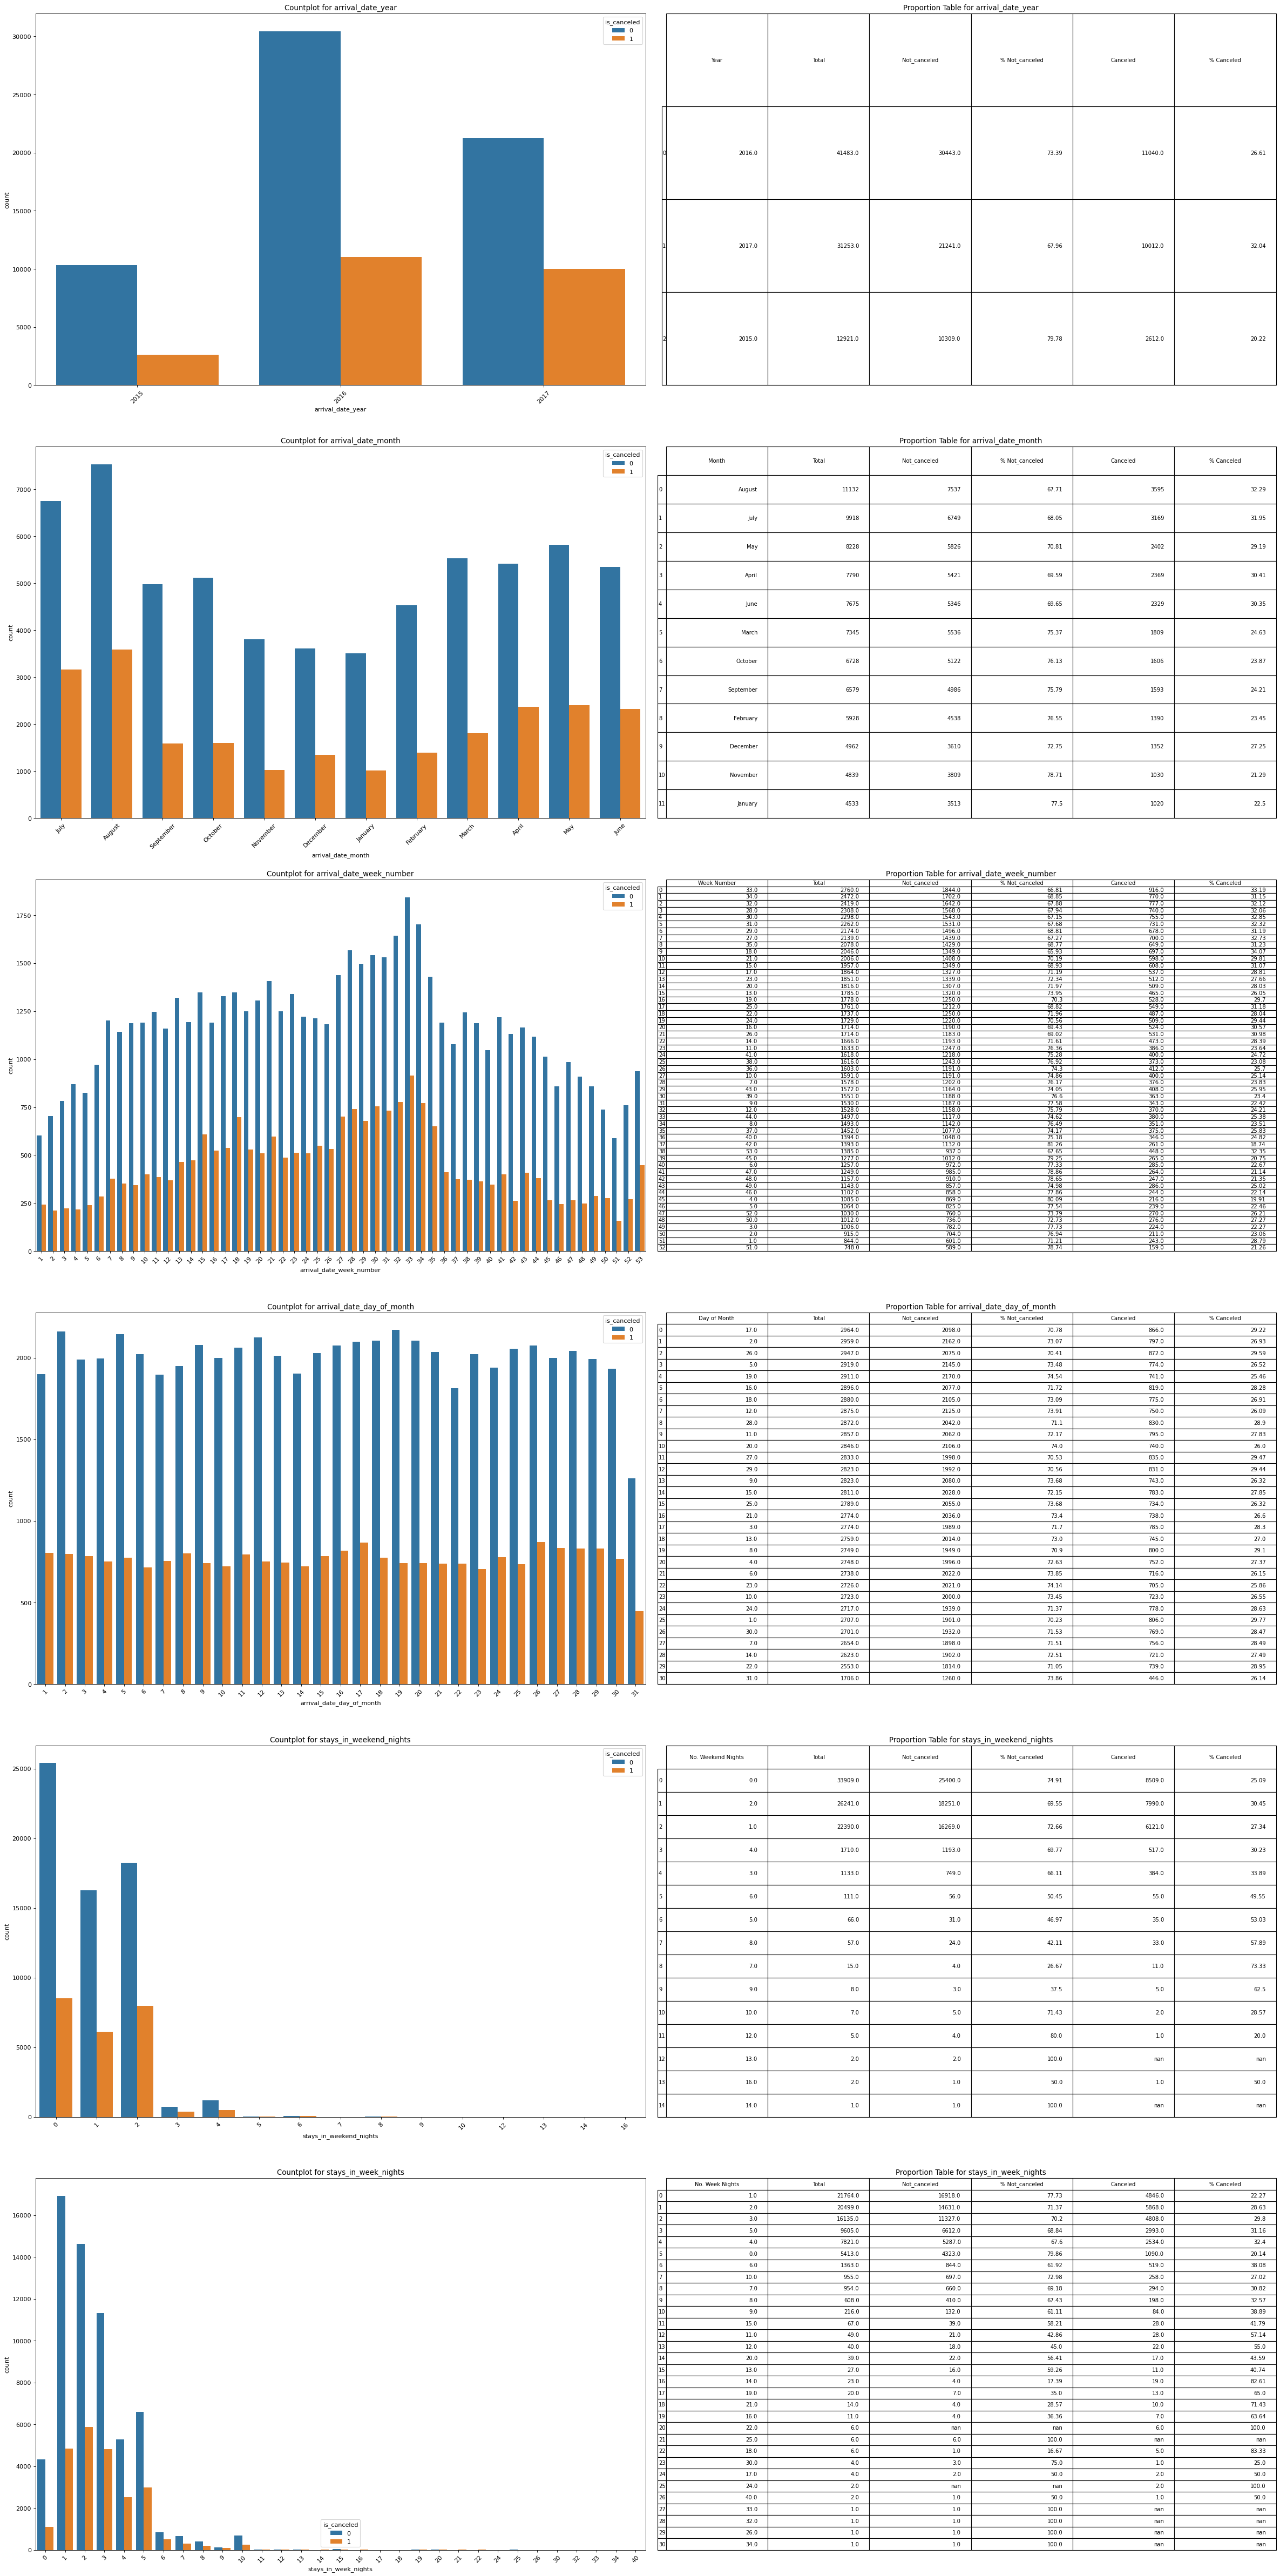

In [48]:
fig, axes = plt.subplots(6, 2, figsize = (30,10*len(datetime_features)))

# dictionary to label proportion table
prop_dict = {'arrival_date_year':'Year', 
             'arrival_date_month':'Month', 
             'arrival_date_week_number':'Week Number', 
             'arrival_date_day_of_month': 'Day of Month', 
             'stays_in_weekend_nights':'No. Weekend Nights', 
             'stays_in_week_nights': 'No. Week Nights'}

for i, feature in enumerate(datetime_features):
    sns.countplot(data = df, x = feature, hue = 'is_canceled', ax = axes[i][0])
    axes[i][0].tick_params(axis='x', rotation=45)
    axes[i][0].set_title(f'Countplot for {feature}')

    prop_table = proportion_table(df, feature, prop_dict.get(feature), show = False)

    # Display the proportion table in the subplot
    axes[i][1].axis('off')
    table = axes[i][1].table(cellText=prop_table.values, colLabels=prop_table.columns, rowLabels=prop_table.index, bbox=[0.0, 0.0, 1.0, 1.0])

    # Set the font size of the table cells
    table.auto_set_font_size(False)
    table.set_fontsize(9)  # Set the font size to 12

    # # Enable text wrapping within the cells
    # table.auto_set_column_width(col=list(range(len(prop_table[0]))))
    # table.set_fontsize(12)

    axes[i][1].set_title(f"Proportion Table for {feature}")
    
plt.tight_layout(pad = 2.0)

The plot of arrival_date_year clearly shows that the number of hotel bookings in our dataset peaked in 2018, this is likely because the data we have spans from July 2015 to August 2017, hence 2018 is the only year we have complete data for. It is therefore more insightful to examine the proportions table displayed nextby. From this table we see that the percentage of cancelled bookings steadily rose between 2015 and 2017. This could imply that the arrival year might have a large impact in whether a booking is cancelled.

The plot illustrating arrival month shows a seasonal trend in the number of hotel bookings. As we might expect, during the summer months the number of hotel bookings peaks and then drop to its lowest levels in December and January. At this point, we note again that the dataset we have starts at the start of July and ends at the end of August. Therefore we have data spanning three years for these particular months, hence the largest bins in the histogram correspond to July and August. However, we argue that this does not mean our observation of a seasonal trend is invalid because we can see the trend appear in the months surrounding these. The same seasonal trend does not appear in the percentage of booking that are canceled, implying that there might not be a strong relationship between cancellations and month of arrival.

We can draw the same conclusions about week number of arrival as we did from month of arrival. Implying also that we would not expect week number of arrival to be an important feature in our classification

For the day of arrival, the countplot shows that the numbers are very constant thorughout all days of the month, thus there does not appear to be any relationship between day of arrival and both cancelled and not cancelled bookings. One interesting observation we can make from the plot is that booking numbers tail off on the 31st day of the month. This is to be expected because only seven months a year have a 31st day.

The countplot of number of weekend nights stayed in the hotel peaks at 0 nights falls a bit for 1 night and then form a secondary lower peak on 2 nights. This could be explainied by customers preferring to stay for the whole weekend if they can. After 2 nights the distribution falls to close to zero for the remaining number of weekend nights. There does not appear to be a large difference in the proportions of bookings that are cancelled a the number of weekend nights stayed, again this implies that this feature will not have a large effect on cancellations.

Finally, the countplot for weekday nights stayed shows that the most common number of week nights stayed in the hotel was 2, with the number of bookings quickly tailing off after this. There is a second peak at 5 week days corresponding most likely to those who stay for a whole week. On inspection of the proportion table, we see that the proportion of bookings cancelled peaks after 10 weekday nights are stayed, with values exceeding 80%. The number of observations with these number of weekday nights is very low, all much less than 100 unique bookings. Therefore, we would expect these small number of observations to skew our model. Therefore we decide to remove observations where the number of weekday nights stayed is greater than or to 10.

#### **2.4.3 Categorical Variables: *Personal Information***

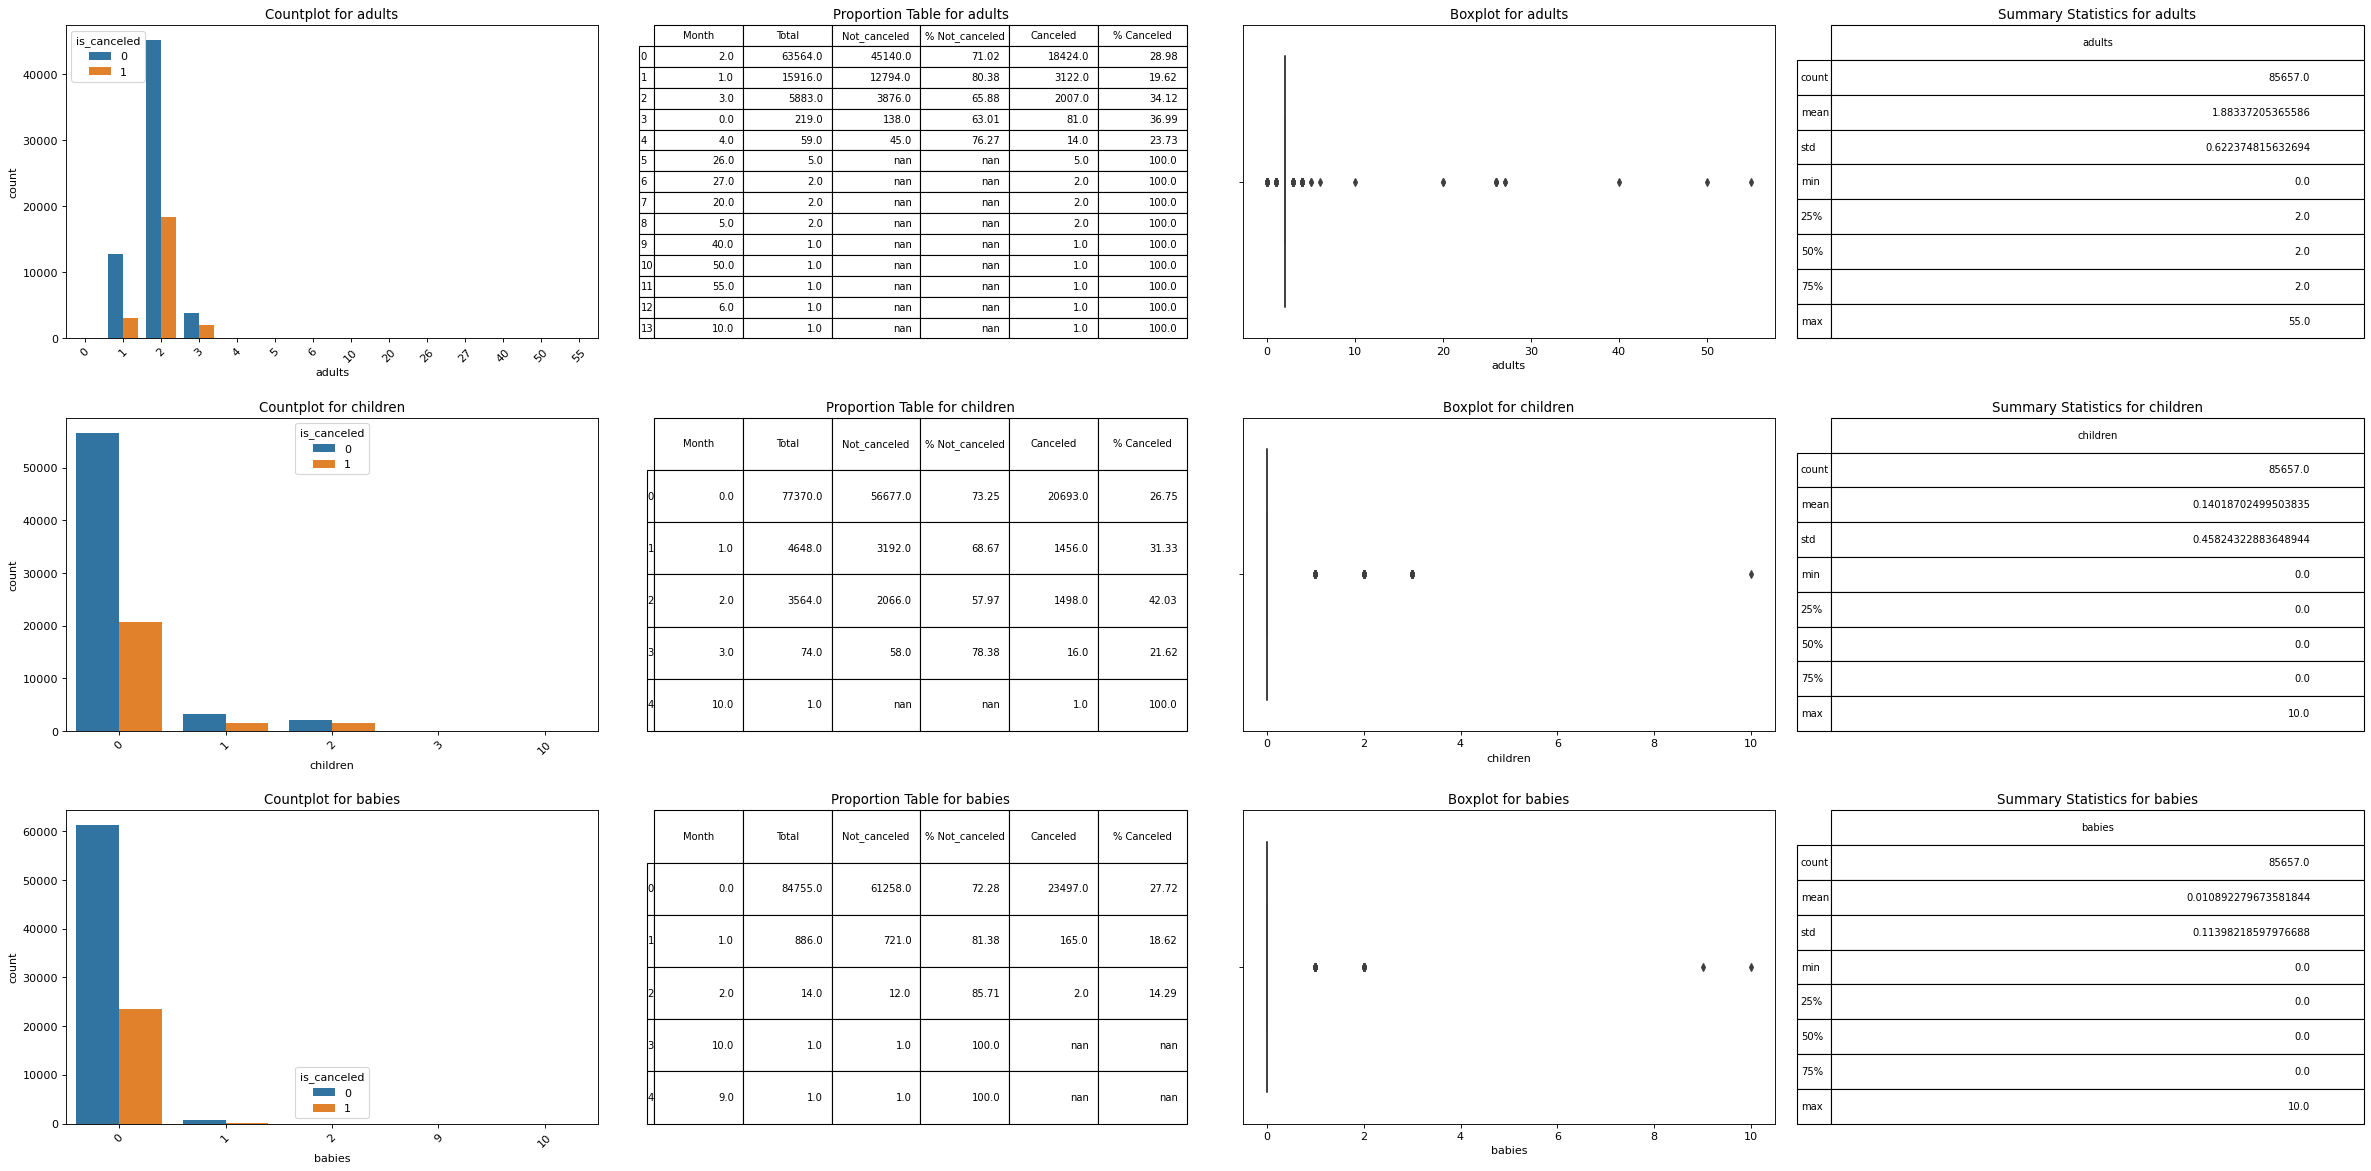

In [49]:
# Personal information
personal_features = ['adults', 'children','babies']

fig, axes = plt.subplots(len(personal_features), 4, figsize = (30,5*len(personal_features)))

for i, feature in enumerate(personal_features):
    ## Countplot ##
    sns.countplot(data = df, x = feature, hue = 'is_canceled', ax = axes[i][0])
    axes[i][0].tick_params(axis='x', rotation=45)
    axes[i][0].set_title(f'Countplot for {feature}')

    ## Proportion Table ##
    prop_table = proportion_table(df, feature, 'Month', show = False)
    axes[i][1].axis('off')
    table = axes[i][1].table(cellText=prop_table.values, colLabels=prop_table.columns, rowLabels=prop_table.index, bbox=[0.0, 0.0, 1.0, 1.0])
    table.auto_set_font_size(False)
    table.set_fontsize(9)  # Set the font size to 9
    axes[i][1].set_title(f"Proportion Table for {feature}")

    ## Boxplot ## 
    sns.boxplot(data = df, x = feature, ax = axes[i][2])
    axes[i][2].set_title(f"Boxplot for {feature}")

    ## Summary Statistics ##
    sum_stats = df[feature].describe().to_frame()
    axes[i][3].axis('off')
    table = axes[i][3].table(cellText=sum_stats.values, colLabels=sum_stats.columns, rowLabels=sum_stats.index, bbox=[0.0, 0.0, 1.0, 1.0])
    table.auto_set_font_size(False)
    table.set_fontsize(9)  # Set the font size to 9
    axes[i][3].set_title(f"Summary Statistics for {feature}")
    
plt.tight_layout(pad = 2.0)



On investigation of the 'adults' feature we see that perhaps unsurprisingly the most common number of adults in a booking is 2 both cancelled and not cancelled bookings. This is corroborated by the summary statistics and the boxplot which show that the median number of adults is 2 as well as first and third quartile. The summary statistics also show that the max value for number if adults is 55 this sounds like an erroneous outlier. Indeed, on inspection of the boxplot and the proportion table we see that there are multiple outliers. For this reason we decide to remove observations with 10 or more adults as they may have negative consequences on our model. These outliers that we remove only account for 13 observations out of a total of around 80000.

For the 'children' feature we see that almost all observations have between 0 and 3 children apart from one observation with 10 children. We believe this observation to be an outlier because it is over 20 standard deviations away from the mean, hence this observation will also be removed.

Finally, we examine the 'babies' feature. The barchart shows that the majority of bookings, both cancelled and not cancelled, have 0 babies. The boxplot does show that there are two observations with 9 and 10 observations respectively. We treat these as outliers and remove them from the dataset

#### **2.4.4 Categorical Variables: *Booking Information***

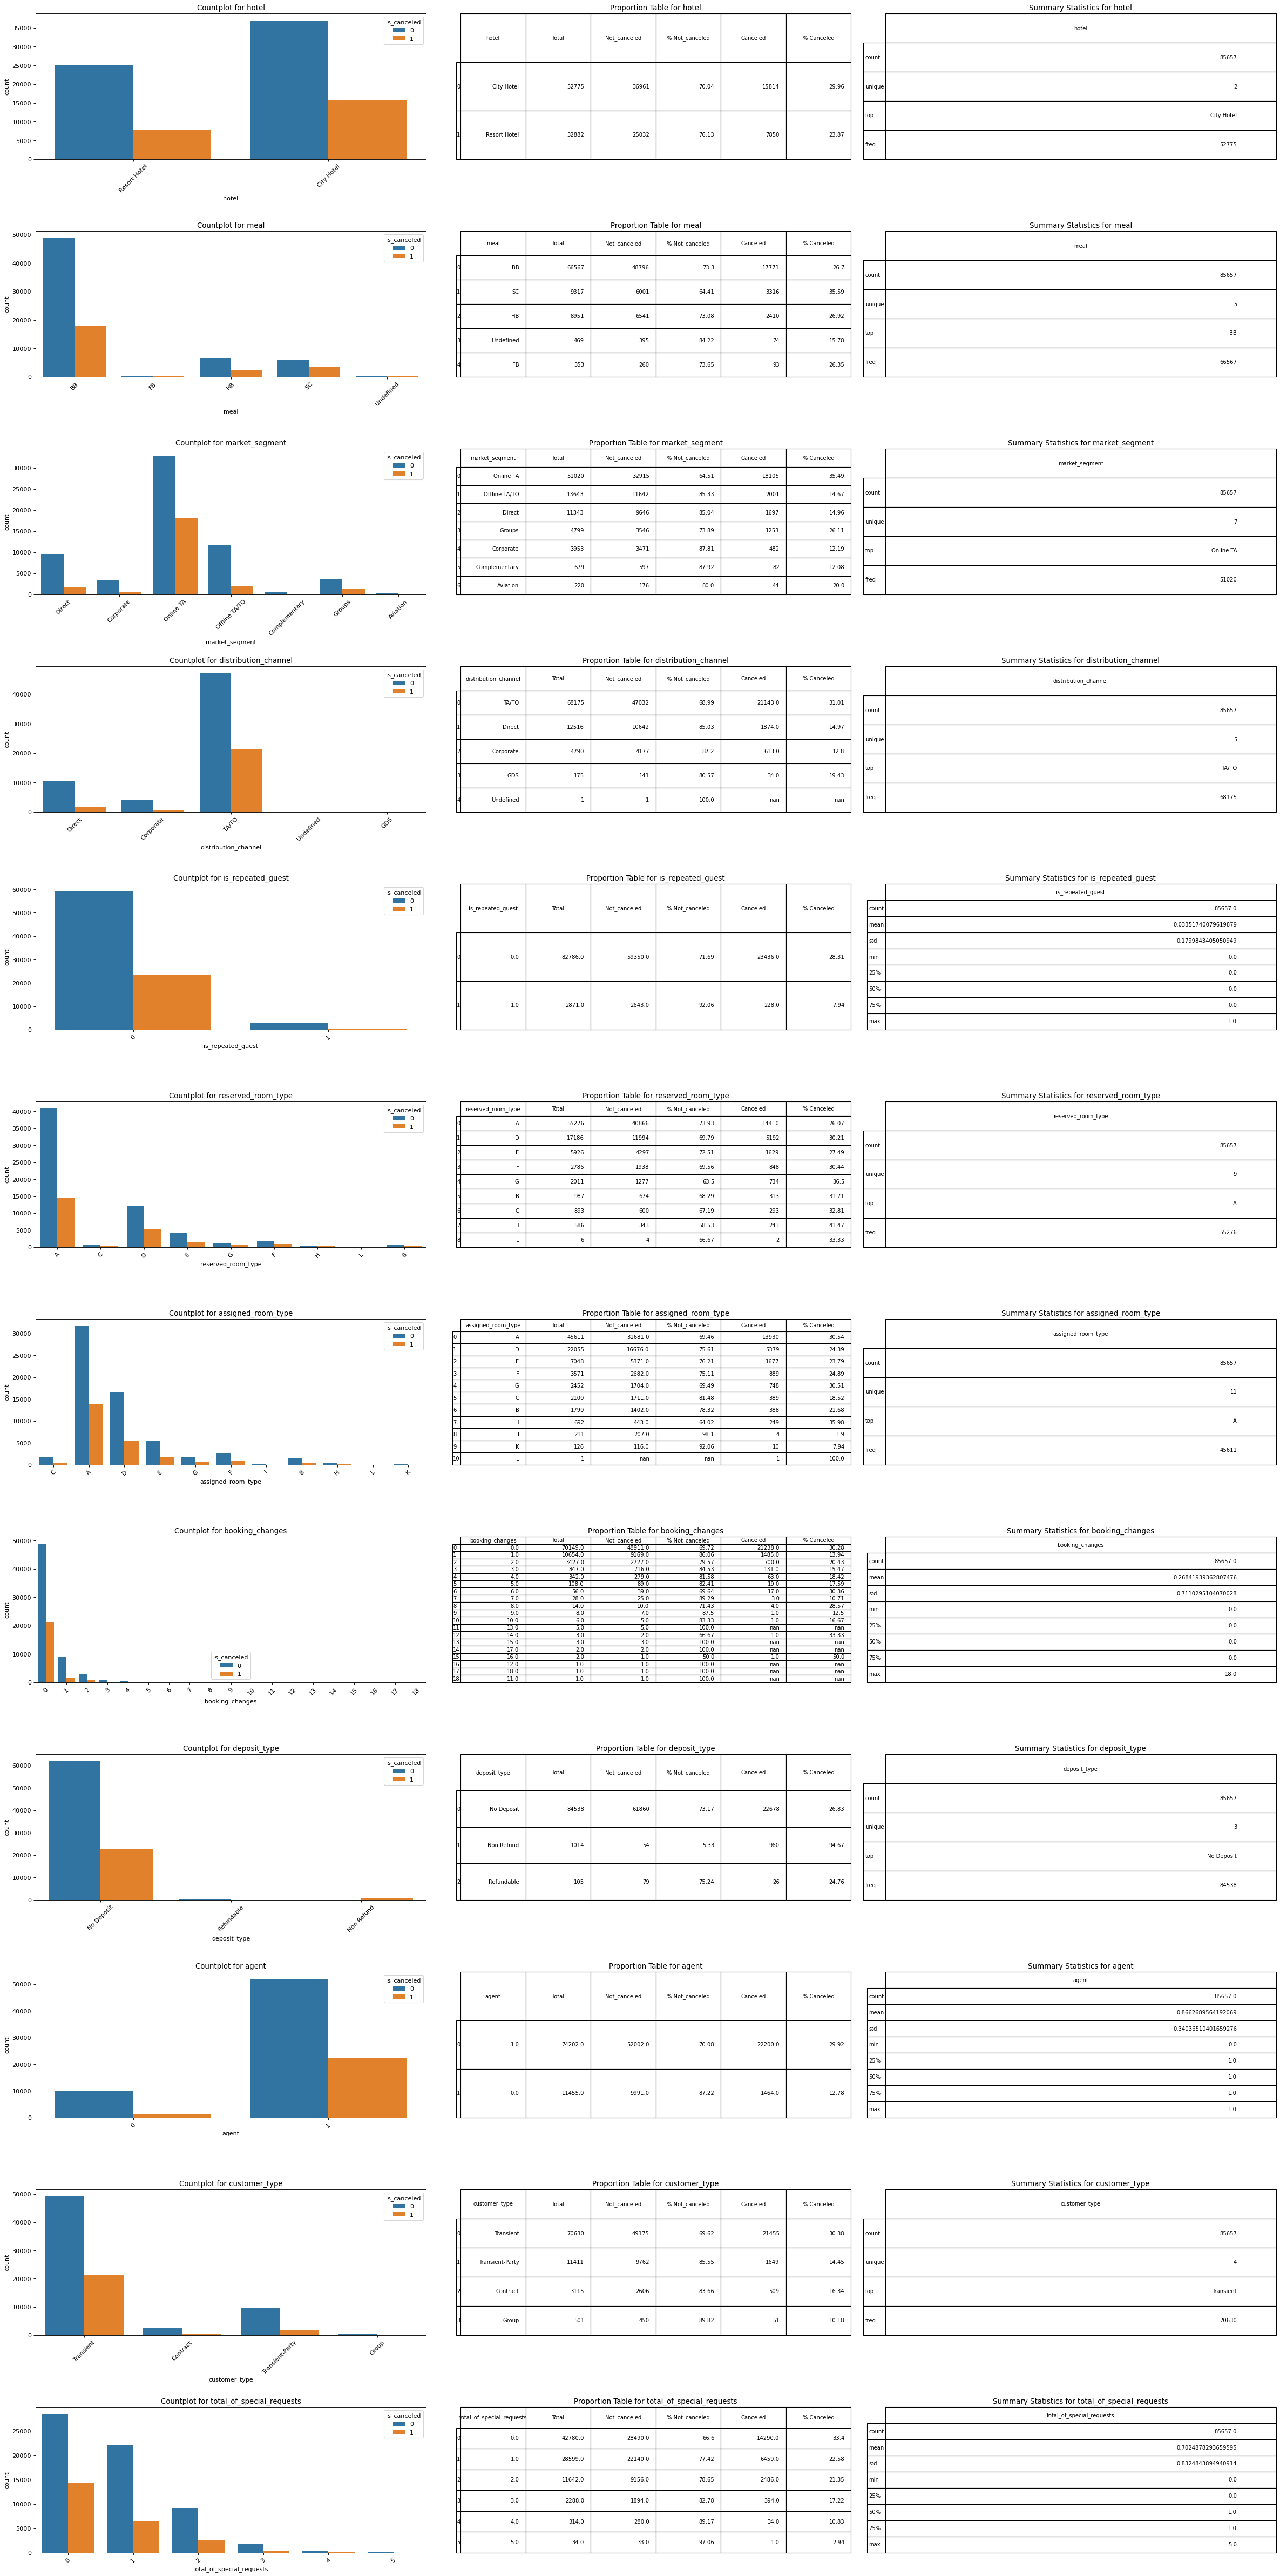

In [50]:
# Booking Information
booking_features = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 
                    'deposit_type', 'agent', 'customer_type', 'total_of_special_requests']

fig, axes = plt.subplots(len(booking_features), 3, figsize = (30,5*len(booking_features)))

for i, feature in enumerate(booking_features):
    ## Countplot ##
    sns.countplot(data = df, x = feature, hue = 'is_canceled', ax = axes[i][0])
    axes[i][0].tick_params(axis='x', rotation=45)
    axes[i][0].set_title(f'Countplot for {feature}')

    ## Proportion Table ##
    prop_table = proportion_table(df, feature, feature, show = False)
    axes[i][1].axis('off')
    table = axes[i][1].table(cellText=prop_table.values, colLabels=prop_table.columns, rowLabels=prop_table.index, bbox=[0.0, 0.0, 1.0, 1.0])
    table.auto_set_font_size(False)
    table.set_fontsize(9)  # Set the font size to 9
    axes[i][1].set_title(f"Proportion Table for {feature}")

    ## Summary Statistics ##
    sum_stats = df[feature].describe().to_frame()
    axes[i][2].axis('off')
    table = axes[i][2].table(cellText=sum_stats.values, colLabels=sum_stats.columns, rowLabels=sum_stats.index, bbox=[0.0, 0.0, 1.0, 1.0])
    table.auto_set_font_size(False)
    table.set_fontsize(9)  # Set the font size to 9
    axes[i][2].set_title(f"Summary Statistics for {feature}")
    
plt.tight_layout(pad = 2.0)

The barchart for the ‘hotel’ feature shows that over the period of interest more bookings were made to the city hotel then the resort hotel. The proportion table shows us that the city hotel had a higher percentage of cancellations with 29.7% of booking s being cancelled compared to the resort hotel where only 23.4% of bookings were cancelled. In this feature there is no indication of erroneous entries or outliers, all observations were made to one of the two types of hotel.

The ’meal’ feature is split into 5 categories, these are:
-	Undefined/ SC – ‘self catered’ no meal package provided
-	BB – ‘bed and breakfast’, one meal (breakfast) has been provided
-	HB – ‘half board’, two meals provided, usually breakfast and dinner
-	FB – ‘full board’, three meals provided.

Since undefined and SC correspond to the same category we will change all observations with undefined meals to SC as this will stop us having two labels corresponding to the same thing.
The proportion table shows that the vast majority of bookings are for bed and breakfast. The meal category with the highest cancellation percentage is self catered with 35% of booking cancelled even when we combine with the undefined category it will still have greater than 30% cancellations which is much more than all the other categories in the feature, which are all around 26%. Therefore, we would expect meal to be a useful feature for our classification model.

For the ‘market_segment’ feature we see that there are 7 categories: online TA, offline TA/TO, Direct, Groups, Corporate, Complementary and Aviation. Here we know that TA and TO refer to travel agent and tour operator respectively. We see that the more than half of all bookings are through online travel agents which isn’t surprising considering that our data was gathered between 2015 and 2017 when online travel agents were well-established and mainstream. Online travel agents also have a cancellation rate of 35% which is considerably higher than all other categories. For this reason we would expect ‘market_segment’ to be an important feature in our classification.

The barchart for ‘distribution_channel’ shows the most common distribution channel is TA/TO, this is also the category with the greatest proportion of cancellations at 30%. All other distribution channels have cancellation rates between 12-18%. Other points of interest in this feature are the ‘GDS’ feature which stands for ‘Global Distribution System’ and refers to an online network that connect travel agents directly with the central reservations systems for airlines and hotels. Further, the proportion table shows that there is one value with undefined distribution channel. We will remove this observation as we lack enough information to robustly impute it.

Examining the barchart for the ‘is_repeated_guest’ feature we see that most of the booking made are from non-repeat customers. The proportions show us that 28% of non-repeat customers cancel their bookings but only 7% of repeat customers cancel their bookings. This disparity in cancelling proportion implies that this feature might be useful for our classification. We can also see from the table that all values in this feature are either 0 or 1 so there are no erroneous values we must consider.

For the ‘reserved_room_type’ and the ‘assigned_room_type’ features we see that room type A is the most common room type reserved and assigned. For anonymity purposes we do not know what the letters correspond to so there is not many more conclusions we can draw from these features. We can note that neither feature has values that do not fit into the standard categories, so no additional data cleaning is necessary for these features.

For ‘deposit_type’ we see that most bookings are made with no deposit paid. Interestingly, the deposit type with the largest percentage of cancellations is non-refund with 94%. 

The 'agent' feature shows a clear difference in the proportion of cancellation when booked through an agent compared to those not booked through an agent. Surprisingly 29% of bookings made through an agent were cancelled whereas only 12% of those not made through an agent were cancelled. There are no erroneous values in this feature - all observations are either 0 or 1.

For 'customer_type' by far the greatest, both in terms of absolute number of bookings and proportion of cancellations, is the transient category. The other three categories only have between around 10-16% cancellation rates. Again there are no erroneous values in this feature to consider.

The final feature we consider at this time is 'total_of_special_requests'. We can see a clear trend that as the number of sepcial requests increases the number of bookings in that category decreases as well as the proportion of cancellations. Perhaps implying that this is a useful feature for classifying our data. Again we have that there are no erroneous values in this feature to consider.


#### **2.4.3 Categorical Variables: *Other Information***
In this section we will consider the remaining features: namely 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces' and 'country'. Specifically, these are the features we have identified as requiring a closer examination, especially in regard to outliers.

        days_in_waiting_list
2                          0
3                          0
4                          0
6                          0
7                          0
...                      ...
119385                     0
119386                     0
119387                     0
119388                     0
119389                     0

[85657 rows x 1 columns]


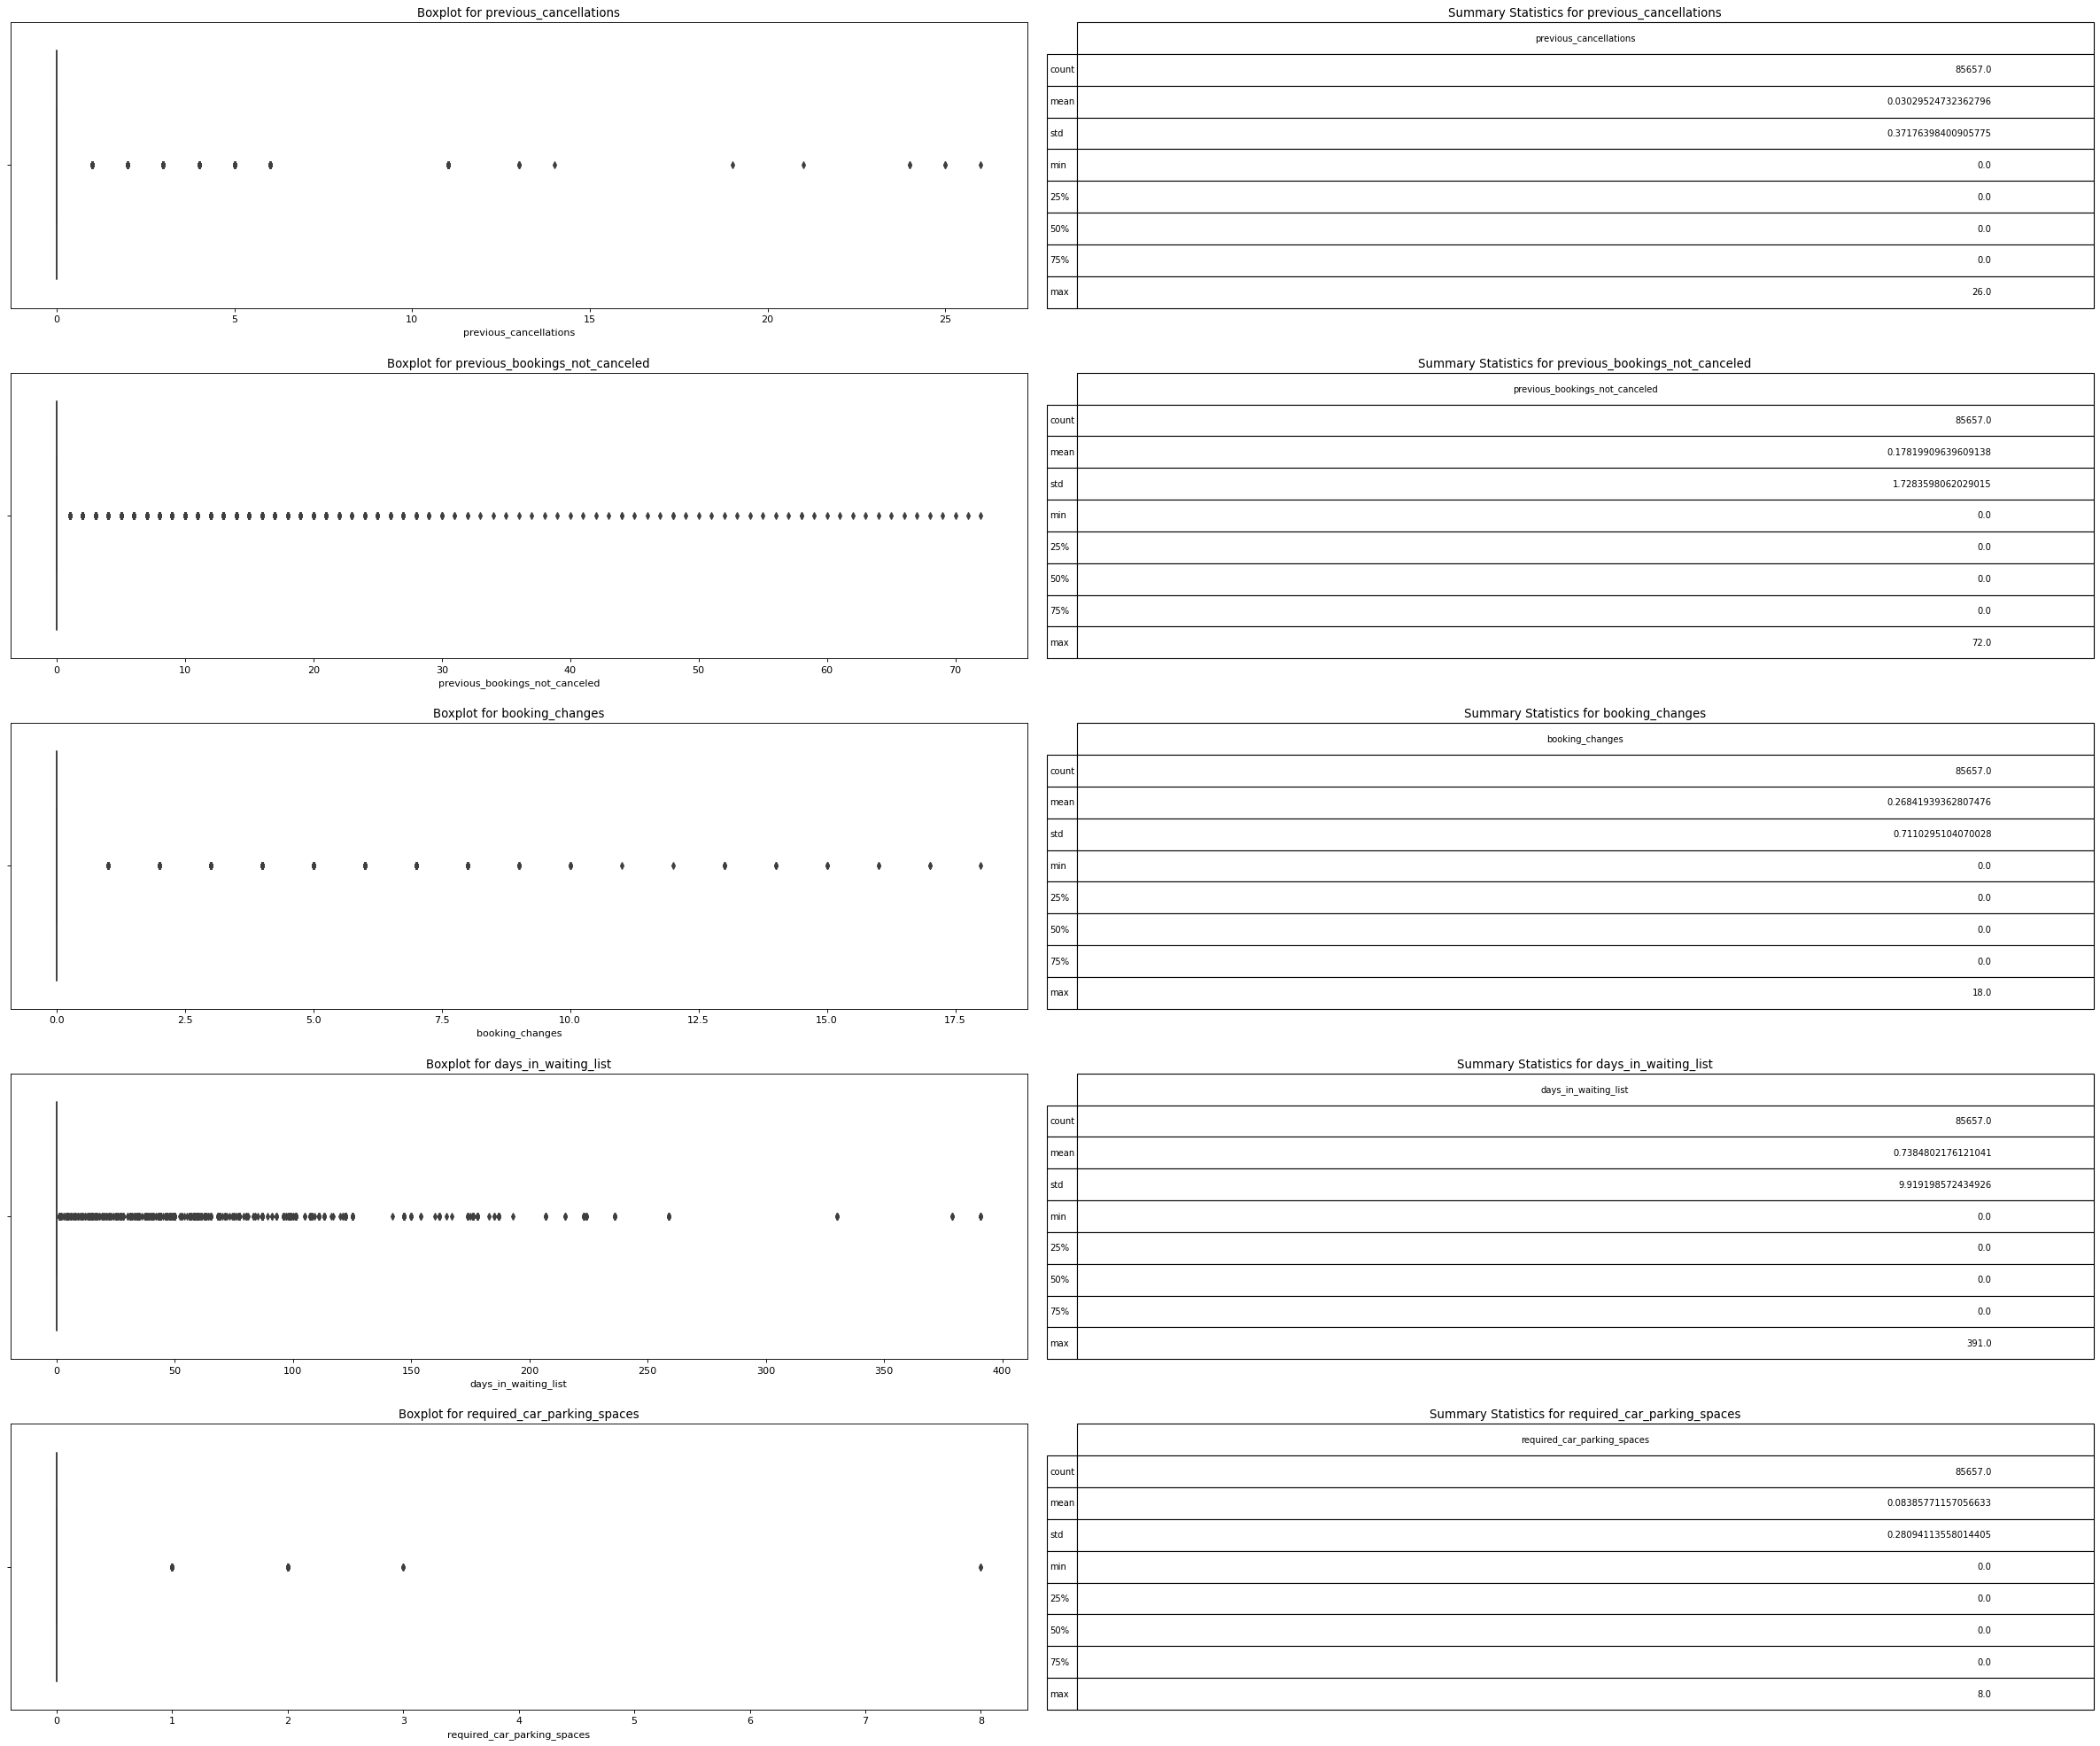

In [51]:
other_features = ['previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces']

#, 'days_in_waiting_list'
fig, axes = plt.subplots(len(other_features), 2, figsize = (30,5*len(other_features)))

for i, feature in enumerate(other_features):
    
    ## Boxplot ## 
    sns.boxplot(data = df, x = feature, ax = axes[i][0])
    axes[i][0].set_title(f"Boxplot for {feature}")

    ## Summary Statistics ##
    sum_stats = df[feature].describe().to_frame()
    axes[i][1].axis('off')
    table = axes[i][1].table(cellText=sum_stats.values, colLabels=sum_stats.columns, rowLabels=sum_stats.index, bbox=[0.0, 0.0, 1.0, 1.0])
    table.auto_set_font_size(False)
    table.set_fontsize(9)  # Set the font size to 9
    axes[i][1].set_title(f"Summary Statistics for {feature}")
    
plt.tight_layout(pad = 2.0)

print((df[['days_in_waiting_list']]))

The summary statistics for the feature 'previous_cancellations' show that the mean is roughly 0.03 with standard deviation around 0.4. Yet the maximum value is 26, this suggests the presence of outliers. The boxplot clearly shows that there is indeed outliers. Of note is the fact that the outliers greater than 10 are more spaced out then the ones less then 10. We therefore decide that 10 is reasonable cutoff for our outliers and remove observations with 10 or more previous cancellations.

For 'previous_bookings_not_cancelled', the boxplot shows that the outlier are evenly spaced, appearing to cover all values between 1 and 72. Therefore, we decide not to remove any observations based on this feature because there is no obvious break in the outliers. We draw the exact same conclusions for the 'booking_changes' feature.

For 'days_in_waiting_list' there are a large number of observations with 0 days in the waiting list, indicating they got their booking was confirmed on the same day. Yet there are also a large number of observations where the number of days in the waiting list is much larger. We do not remove any of these values because although it seems unlikely someone would be in the waitnig list for 400 days it is possible.

Finally, for 'required_car_parking_spaces' we can clearly see an outlying value at 8 which we will remove from the dataset.

Our final visualisation in this section is for the 'country' feature. Here we use a heatmap imposed over a geographical map of the wolrd to illustrate where guests are coming from.

In [52]:

guest_city = df[df['is_canceled'] == 0]['country'].value_counts().reset_index()
guest_city.columns = ['Country', 'No of guests']
guest_city

basemap = folium.Map()
guests_map = px.choropleth(guest_city, locations = guest_city['Country'],
                        color = guest_city['No of guests'], hover_name = guest_city['Country'])
guests_map.show()

We can see that most of the countries are either light blue, indicating no one from that country stayed in the hotel, or dark blue indicating very few people did. Most of the light blue countries are generally considered relatively wealthy, for example these include Yemen, Somalia and Afghanistan. An interesting outlier in this observation is Canada, it is the only G20 country from which no one booked either hotel. 

Most of the bookings are concentrated around the relatively wealthy country of western Europe, with almost 17000 bookings coming from Portugal and 8400 coming from the UK.



We now remove all the outliers that we have discussed in this section in the next code block.

In [53]:
# Week nights stayed more than 10
week_nights = (df.stays_in_week_nights > 10)

# 10 or more adults
adults = (df.adults > 10)

# 10 children
children = (df.children == 10)

# 9 or more babies
babies = (df.babies >= 9)

# Undefined distribution channel
undef_dc = (df.distribution_channel == 'undefined')

# Previous cancellations greater then 10 
cancellations = (df.previous_cancellations >= 10)

# 8 Parking spaces
car_spaces = (df.required_car_parking_spaces == 8)

# Delete these anomolous observations from the dataframe
bool_series = week_nights|adults|children|babies|undef_dc|cancellations|car_spaces
df = df[~bool_series.reindex(df.index)]

# Rename undefined meals to SC
df['meal'].replace({'Undefined': 'SC'}, inplace=True)

### **2.5 Data Encoding**

In [54]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

le_dict = defaultdict(LabelEncoder)

# apply label encoder to all columns
encoded_df = df.apply(lambda x: le_dict[x.name].fit_transform(x))

# inverse label encoder, for later use 
df = encoded_df.apply(lambda x: le_dict[x.name].inverse_transform(x))

# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

### **2.6 Correlation**
In this section we will examine any correlation between features as well as identifying the features with the largest correlation to the response variable.


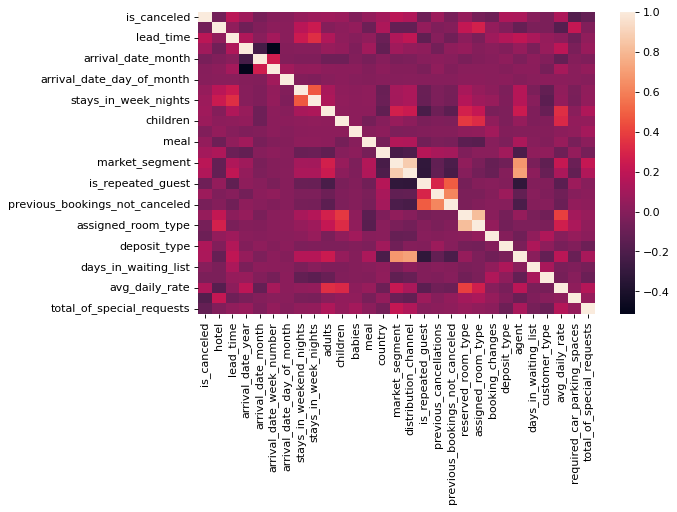

In [55]:
# Correlation heatmap - Talk about this
corr = encoded_df.corr()
plt.figure()
sns.heatmap(corr)
plt.show()

In general, there is very little correlation between the features in our dataset. We will now examine in more detail the correlation between our features and our response variable. 

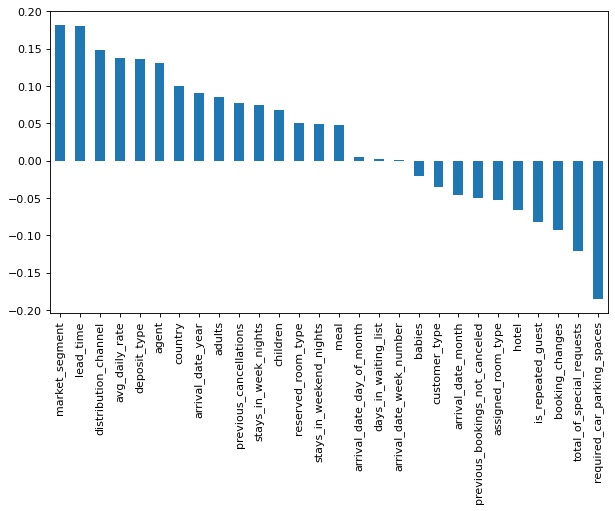

In [56]:

fig, ax = plt.subplots(figsize=(9,5))
encoded_df.corr()["is_canceled"].sort_values(ascending=False)[1:].plot(kind="bar", ax=ax)
plt.show()

The features with the strongest positive correltations to the response are: 'market_segment', 'lead_time' and 'distribution_channel'. The features with the strongest negative correlations to the response are: 'required_car_parking_spaces', 'total_of_special_requests' and 'booking_changes'. We would thus expect these features to play an important part in our classification model. 


Note the features 'arrival_date_day_of_month', 'days_in_waiting_list' and 'days_in_waiting_list' have almost zero correlation with the response variable. We suspect that it is possible to drop these features from our dataset. Before we do so we need to justify our decision with a hypothesis test. We use the 'pearsonr' function from scipy, this returns the Pearson correlation coefficient between the response and a feature. It also returns the p-value associated with a test of the null hypothesis that the distributions underlying the samples are uncorrelated and normally distributed. The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets. Therefore we will remove features with p-values above a decided threshold. The threshold we chose is 0.05 as this is a standard choice in statistics.

In [57]:
from scipy.stats import pearsonr
# Create empty list to store features to drop
drop_features = []

# Iterate over all features and perform hypothesis test
for feature in encoded_df.columns:  
    cor, p_value = pearsonr(encoded_df[feature], encoded_df['is_canceled'])
    #print(feature, cor, p_value)
    if p_value > 0.05:
        drop_features.append(feature)

# Drop features with low correlation to response variable in both Dataframes
encoded_df = encoded_df.drop(drop_features, axis=1)
df = df.drop(drop_features, axis=1)
print(f'The features we will drop are: {drop_features}')

The features we will drop are: ['arrival_date_week_number', 'arrival_date_day_of_month', 'days_in_waiting_list']


We see that as we expected the features that are insignificantly correlated with our response are 'arrival_date_week_number', 'arrival_date_day_of_month' and 'days_in_waiting_list', hence these features have been dropped from both the encoded and unencoded dataframes.

In [58]:
raise 'End of Section 2'

TypeError: exceptions must derive from BaseException

---
## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a logistic regression model, a classification tree, and a SVC model and ultimately settled on the logistic regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the logistic regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

In [59]:
# Model Evaluation Function

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval(y_true, y_pred, confusion=True, AUC = True, ROCplot=True, precision=True, f1 = True, recall = True, accuracy=True):
    ''' Function to evaluate a model. Takes inputs true y and predicted y 
    and prints evaluation metrics. Metrics are confusion matrix, AUC curve, ROC plot,
    precision value, f1 value, recall value and accuracy value. These can be individually
    toggled off manually by setting them to False.'''
    if accuracy: 
        print("Accuracy:", accuracy_score(y_true, y_pred))
    if precision: 
        print("Precision:", precision_score(y_true, y_pred))
    if recall: 
        print("Recall:", recall_score(y_true, y_pred))
    if f1: 
        print("F1 Score:", f1_score(y_true, y_pred))
    if confusion:
        print('Confusion Matrix: \n', sklearn.metrics.confusion_matrix(y_true, y_pred))
    if AUC:
        print('AUC: ', sklearn.metrics.roc_auc_score(y_true, y_pred))
    if ROCplot:
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_pred)
        # calculate AUC score
        roc_auc = sklearn.metrics.auc(fpr, tpr)

        # plot ROC curve
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


Here, we define a function to evaluate candidate models for convenience. We used it extensively to narrow down our models before settling on Random Forest. The function takes the test and predicted cancellation data for a model, and returns several of the most commonly used metrics for evaluating a binary model, including AUC and confusion matrices.

We see throughout the report that on ROC plots, there is often only one joint on the curve where usually there would be many. This is because many of the models used do not return a probability and instead a binary classication 0 or 1.

#### Data Formatting

In [70]:
from sklearn.model_selection import train_test_split

sample = encoded_df.sample(frac=0.1, random_state=1)

print(sample.columns)
X = sample.drop('is_canceled', axis = 1)
y = sample['is_canceled']
strat = sample['hotel']

display(sample)

print(len(X))
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42, stratify = strat)

Index(['is_canceled', 'hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'customer_type', 'avg_daily_rate', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')


,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,customer_type,avg_daily_rate,required_car_parking_spaces,total_of_special_requests
118935,0,0,2,2,1,0,1,2,1,0,...,0,5,5,1,0,1,2,8213,0,0
24184,0,1,123,1,8,0,1,2,0,0,...,0,3,7,0,0,1,2,1872,1,1
97528,0,0,291,1,11,0,1,2,0,0,...,1,0,0,0,0,1,3,4547,0,1
7273,1,1,201,1,1,1,3,2,0,0,...,0,3,3,0,0,1,2,6808,0,1
26776,0,1,195,1,1,2,5,2,0,1,...,0,0,0,0,0,1,0,4495,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83837,0,0,21,1,3,0,3,2,0,0,...,0,3,3,0,0,1,2,1441,0,1
114363,0,0,135,2,6,0,1,2,0,0,...,0,0,1,0,0,1,2,6076,0,1
112708,0,0,87,2,8,0,4,2,0,0,...,0,0,0,0,0,1,2,5795,0,0
31239,0,1,0,1,2,1,0,1,0,0,...,0,0,0,0,0,0,2,336,0,0


8528


### Decision tree 🌲

Accuracy: 0.7646162093342714
Precision: 0.5690164127996221
Recall: 0.58807736896699
F1 Score: 0.5783898940798752
Confusion Matrix: 
 [[36005  7300]
 [ 6751  9638]]
AUC:  0.7097528052547686


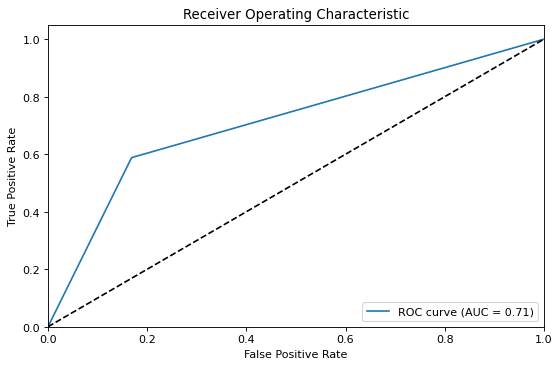

In [61]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)
eval(y_test, y_pred)


In [62]:
from IPython.display import clear_output
import ipywidgets as widgets

def button(function):
    '''Function that makes button to run function'''
    print('Warning, cell takes a wee while to run. Click to proceed.')
    def on_click(arg):
        clear_output(wait=False)
        print(f'Running {function.__name__}...')
    def after_click(arg):
        print(f'Finished {function.__name__}...')
    the_button = widgets.Button(description = f'Click to run {function.__name__}.', layout = {'width':'auto'})   
    the_button.on_click(on_click)
    the_button.on_click(function)
    the_button.on_click(after_click)
    display(the_button)


In [63]:
# Finding the best parameters for decision tree classification

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def do_grid_seach_decision_tree(arg):
    global grid_search
    # Params search space
    parameters = {
        'criterion':['gini','entropy'],
        'max_features': ['sqrt', 'log2'],
        'max_depth':[None, *np.arange(5,15),*np.arange(20,200,10)],
        'min_samples_split': [*np.arange(2,10)],
        'min_samples_leaf': [*np.arange(2,10)]
    }

    tree = DecisionTreeClassifier() # set model
    # Start grid search on param space
    grid_search = GridSearchCV(estimator=tree, param_grid=parameters, cv=5, scoring=['accuracy','precision'], refit='precision')

    # Fit the grid search object to the data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and score
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    
button(do_grid_seach_decision_tree)

Warning, cell takes a wee while to run. Click to proceed.


Button(description='Click to run do_grid_seach_decision_tree.', layout=Layout(width='auto'), style=ButtonStyle…

Accuracy: 0.8078868898046705
Precision: 0.6624199617136445
Recall: 0.6123009335529929
F1 Score: 0.6363751664658507
Confusion Matrix: 
 [[38191  5114]
 [ 6354 10035]]
AUC:  0.747104167272975


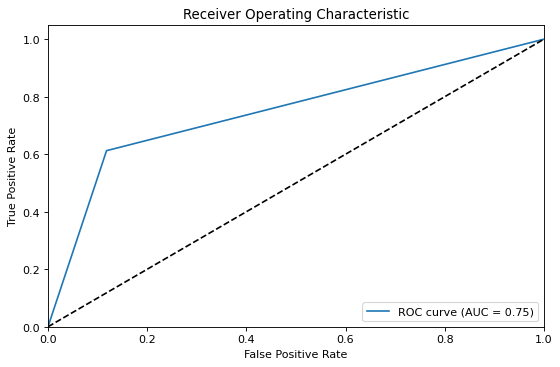

In [64]:
# Set default params
try: grid_search.best_params_
except:
    params = {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 9, 'min_samples_split': 2}
else:
    params = grid_search.best_params_

    
# Using the optimal parameters


tree = DecisionTreeClassifier(**params)
tree.fit(X_train,y_train)

y_pred = tree.predict(X_test)

eval(y_test,y_pred)

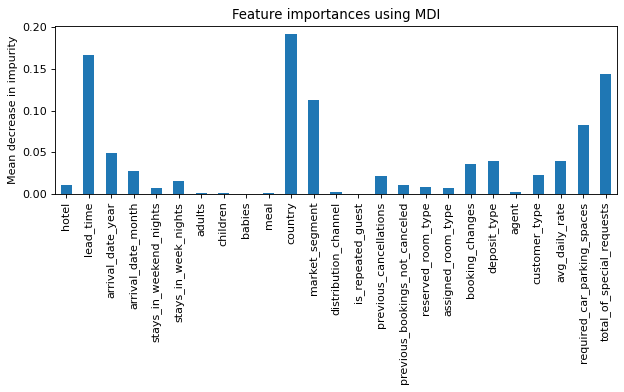

In [65]:
# Code from scikit learn documentation
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = tree.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [66]:
from sklearn.tree import export_graphviz
import os
from pathlib import Path
downloads_path = str(Path.home() / "Downloads") # https://stackoverflow.com/questions/35851281/python-finding-the-users-downloads-folder
os.environ["PATH"] += os.pathsep + downloads_path + r'\windows_10_msbuild_Release_graphviz-7.1.0-win32\Graphviz\bin'
    
tree_data = export_graphviz(
 tree,
 feature_names = X_train.keys(),
 rounded = True, filled = True
 )
    
# For plotting simply
import graphviz 
graph = graphviz.Source(tree_data) 
graph

ModuleNotFoundError: No module named 'graphviz'

### Random forest 🌲🌳🌲🌲

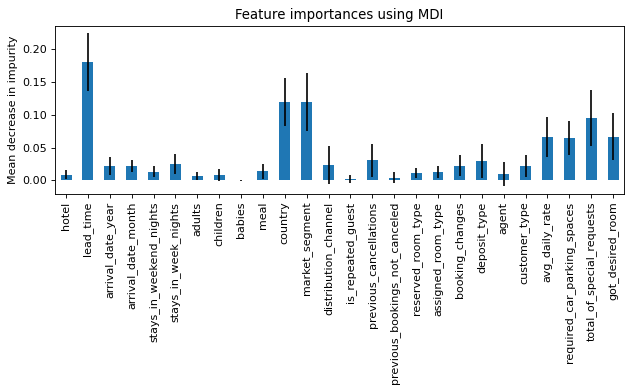

Accuracy: 0.8140703517587939
Precision: 0.742014742014742
Recall: 0.44542772861356933
F1 Score: 0.5566820276497697
Confusion Matrix: 
 [[1804  105]
 [ 376  302]]
AUC:  0.6952125547206138


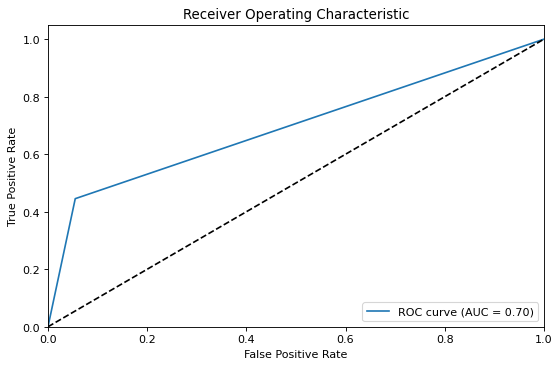

In [ ]:
from sklearn.ensemble import RandomForestClassifier
 
# Create random forest classifier object
# increasing n_estimators to 500 increases runtime withoug meaningfully increasing AUC
# oob_score does not improve model
rf = RandomForestClassifier(**params,n_estimators=1000)

# Train the classifier on the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

# Code from scikit learn documentation
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


eval(y_test, y_pred)


In [ ]:
# Finding the best parameters for Random Forest classification

from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings(str('ignore'))

def do_grid_seach_random_forest(arg):
    global grid_search
    parameters = {
            'n_estimators': [10, 25, 50, 100, 200],
            'criterion':['gini','entropy'],
            'max_depth':[None, *np.arange(5,15),*np.arange(20,100,20)],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [*np.arange(2,10,2)],
            'min_samples_leaf': [*np.arange(2,10,2)]
    }

    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf, param_grid=parameters, cv=5, scoring=['accuracy','precision'], refit='precision')

    # Fit the grid search object to the data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and score
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    
button(do_grid_seach_decision_tree)

Running do_grid_seach_decision_tree...
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 8}
0.8891968325791855
Finished do_grid_seach_decision_tree...


In [74]:
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_iter': [100, 200, 300],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [1, 5, 10],
}

rf = HistGradientBoostingClassifier()

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

eval(y_test,y_pred)

# tree = DecisionTreeClassifier() # set model
# # Start grid search on param space
# grid_search = GridSearchCV(estimator=tree, param_grid=parameters, cv=5, scoring=['accuracy','precision'], refit='precision')

# # Fit the grid search object to the data
# grid_search.fit(X_train, y_train)



Best parameters:  {'learning_rate': 0.1, 'max_depth': 6, 'max_iter': 100, 'min_samples_leaf': 10}
Best score:  0.8240964408023483


/Users/aidangarrity/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but HistGradientBoostingClassifier was fitted without feature names



NotFittedError: This HistGradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'learning_rate': 0.05, 'max_depth': 7, 'min_samples_leaf': 5}
0.8256597052348337
Accuracy: 0.7698492462311558
Precision: 0.6874074074074074
Recall: 0.28518746158574065
F1 Score: 0.40312771503040834
Confusion Matrix: 
 [[4132  211]
 [1163  464]]
AUC:  0.6183017667127414


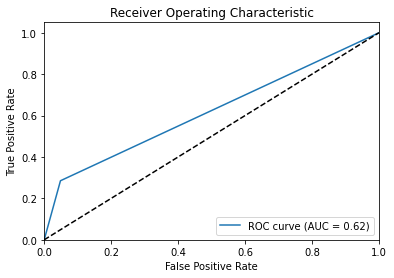

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 5, 10],
}

# Create a HGBCT classifier object
clf = ens.HistGradientBoostingClassifier()

# Use grid search to find the optimal hyperparameters
grid_search = GridSearchCV(
    clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1
)
# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

eval(y_test,y_pred)

Accuracy: 0.7506764592191728
Precision: 1.0
Recall: 0.048672566371681415
F1 Score: 0.09282700421940929
Confusion Matrix: 
 [[1909    0]
 [ 645   33]]
AUC:  0.5243362831858407


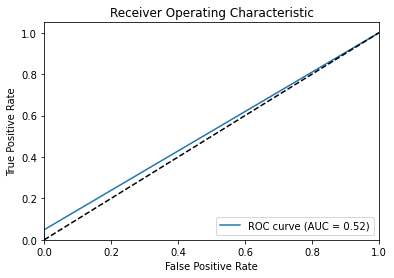

In [ ]:
# Set default params  

try: grid_search.best_params_
except:
    params = {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 8}
else:
    params = grid_search.best_params_

# Using the optimal parameters


tree = RandomForestClassifier(**params)
tree.fit(X_train,y_train)

y_pred = tree.predict(X_test)

eval(y_test,y_pred)

In [ ]:
assert False, "autorun break"

#### Logistic Regression 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# create a logistic regression model
logreg = LogisticRegression()

# fit the model to the data
logreg.fit(X_train, y_train)

# predict using logistic regression 
y_pred = logreg.predict(X_test)

eval(y_test, y_pred)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# from sklearn.linear_model import LogisticRegressionCV
# # Logistic regression: try lasso, ridge, elasticnet, backwards and forwards
# # Add in cross validation later
# lr_lasso = LogisticRegression(penalty='l1', solver = 'saga', max_iter = 10000)
# lr_lasso.fit(X_train, y_train)



#### SVC

In [ ]:
# from sklearn.svm import SVC

# # create a logistic regression model
# svc = SVC()

# # fit the model to the data
# svc.fit(X_train, y_train)

# # predict using logistic regression 
# y_pred = svc.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# print('SVC R-squared score: ', r2)

# accuracy = accuracy_score(y_test, y_pred)
# print('SVC Accuracy: ', accuracy)



#### SVM

Linear SVM Accuracy: 0.7357032457496137
0.1
Accuracy: 0.7357032457496137
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix: 
 [[1904    0]
 [ 684    0]]
AUC:  0.5


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\ellio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



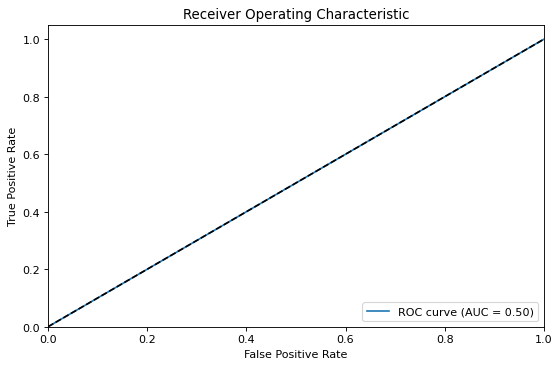

Linear SVM Accuracy: 0.731839258114374
0.5
Accuracy: 0.731839258114374
Precision: 0.4074074074074074
Recall: 0.03216374269005848
F1 Score: 0.05962059620596206
Confusion Matrix: 
 [[1872   32]
 [ 662   22]]
AUC:  0.5076785100004915


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



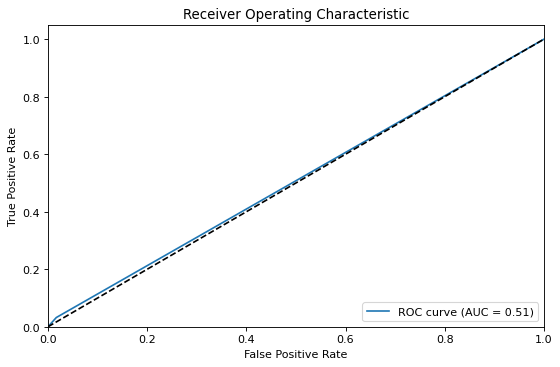

Linear SVM Accuracy: 0.49613601236476046
1
Accuracy: 0.49613601236476046
Precision: 0.31678486997635935
Recall: 0.783625730994152
F1 Score: 0.45117845117845123
Confusion Matrix: 
 [[ 748 1156]
 [ 148  536]]
AUC:  0.5882414369256475


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



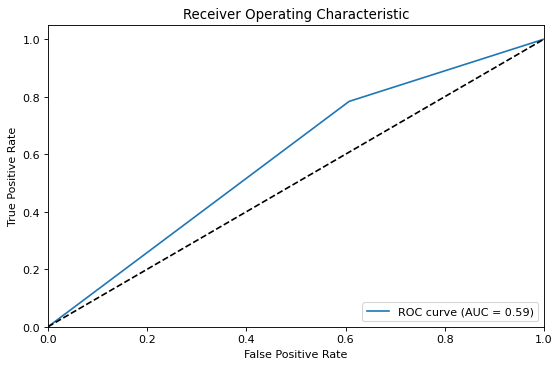

Linear SVM Accuracy: 0.4231066460587326
5
Accuracy: 0.4231066460587326
Precision: 0.30004943153732083
Recall: 0.8874269005847953
F1 Score: 0.4484669375692648
Confusion Matrix: 
 [[ 488 1416]
 [  77  607]]
AUC:  0.5718647107965993


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



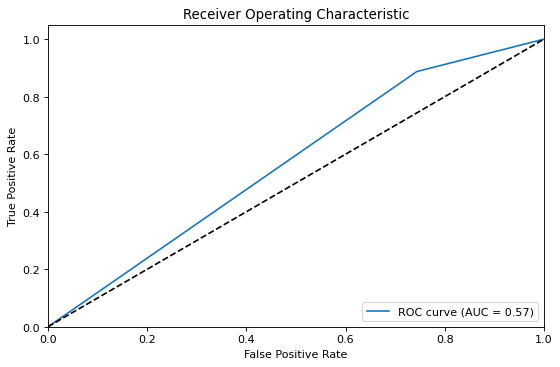

Linear SVM Accuracy: 0.4659969088098918
10
Accuracy: 0.4659969088098918
Precision: 0.3123655913978495
Recall: 0.8494152046783626
F1 Score: 0.45676100628930816
Confusion Matrix: 
 [[ 625 1279]
 [ 103  581]]
AUC:  0.5888357535996855


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



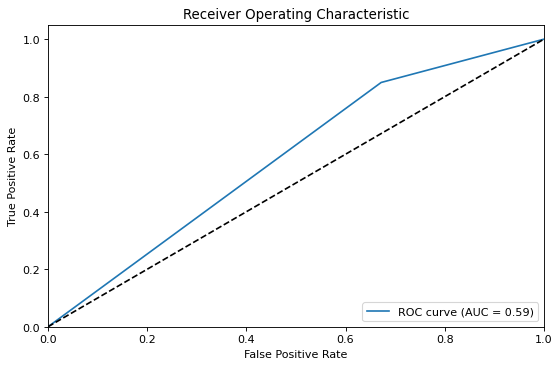

In [ ]:
from sklearn.svm import SVC, LinearSVC

for C in [0.1,0.5,1,5,10]:
    clf = LinearSVC(C=C)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Linear SVM Accuracy:", accuracy)

    print(C)
    eval(y_test, y_pred)

# clf = SVC(kernel='poly')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Polynommial Accuracy:", accuracy)

# clf = SVC(kernel='rbf')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("RBF Accuracy:", accuracy)

# clf = SVC(kernel='sigmoid')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Sigmoid Accuracy:", accuracy)

#### Random Forest

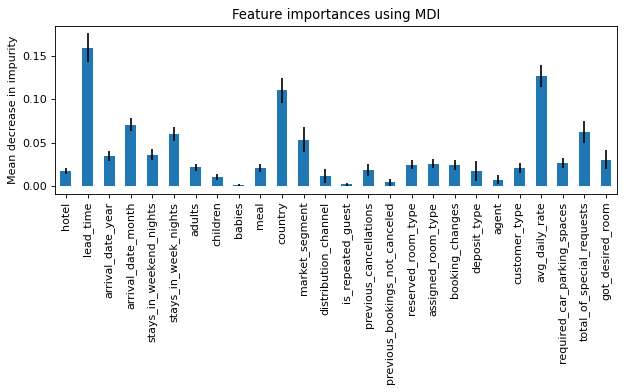

Accuracy: 0.8133693972179289
Precision: 0.6998011928429424
Recall: 0.5146198830409356
F1 Score: 0.5930918281381634
Confusion Matrix: 
 [[1753  151]
 [ 332  352]]
AUC:  0.71765658017593


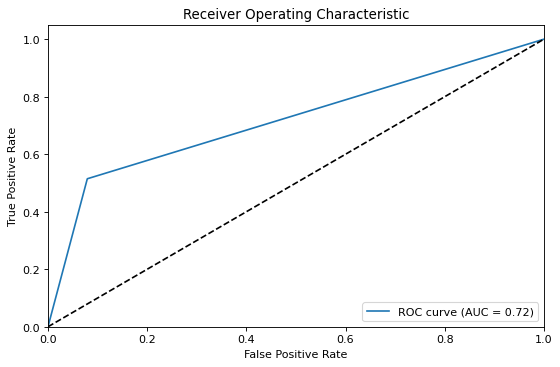

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create random forest classifier object
# increasing n_estimators to 500 increases runtime withoug meaningfully increasing AUC
# oob_score does not improve model
rf = RandomForestClassifier(n_estimators=100)

# Train the classifier on the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

# Code from scikit learn documentation
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


eval(y_test, y_pred)


In [ ]:
# Finding the best parameters for Random Forest classification

from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [10, 25, 50, 100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=parameters, cv=5)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

KeyboardInterrupt: 

Accuracy: 0.8071593533487298
Precision: 0.7472766884531591
Recall: 0.47115384615384615
F1 Score: 0.577927548441449
Confusion Matrix: 
 [[1754  116]
 [ 385  343]]
AUC:  0.7045608802961745


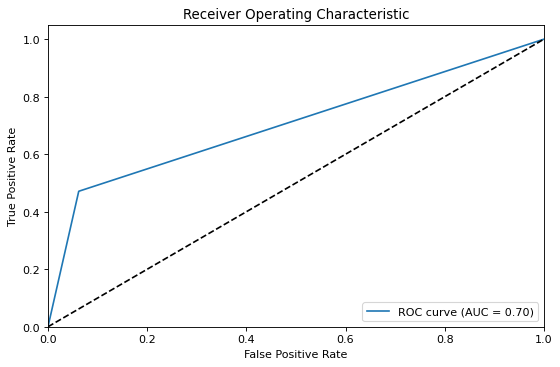

In [ ]:
# Using the optimal parameters

rf = RandomForestClassifier(max_depth=None,max_features='sqrt',min_samples_leaf=1, min_samples_split=5, n_estimators=100)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

eval(y_test,y_pred)


### Neural Nets

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
raise 'STOP HERE TO SAVE LAPTOP'

TypeError: exceptions must derive from BaseException

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30)],
    'activation': ['relu', 'logistic', 'tanh'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'alpha': randint(1, 100),
    'max_iter': randint(100, 1000)
}

random_search = RandomizedSearchCV(
    MLPClassifier(),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (443) reached and the optimization hasn't converged yet.

C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (443) reached and the optimization hasn't converged yet.

C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (443) reached and the optimization hasn't converged yet.

C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (443) reached and the optimization hasn't converged yet.

C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Opt

C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (895) reached and the optimization hasn't converged yet.

C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (895) reached and the optimization hasn't converged yet.

C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of i

Best parameters:  {'activation': 'logistic', 'alpha': 3, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'max_iter': 317, 'solver': 'lbfgs'}
Best score:  0.8042614046706074


C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Accuracy: 0.7994611239414935
Precision: 0.5206043956043956
Recall: 0.6878402903811253
F1 Score: 0.5926505082095387
Confusion Matrix: 
 [[1698  349]
 [ 172  379]]
AUC:  0.7586734426991117


C:\Users\trist\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



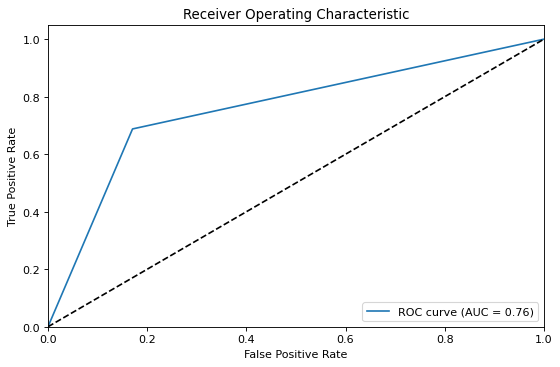

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(30,), activation = 'relu', alpha = 8, learning_rate = 'adaptive', solver = 'lbfgs', max_iter=1000)

mlp.fit(X_train,y_train)

y_pred = mlp.predict(X_test)

eval(y_pred, y_test)


---
## 4. Discussion & Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

Your report must include the following:

* Some discussion of the features that are most important for predicting a cancelation - we do not need discussion of specific coefficient values but direction of the effect should be clear (e.g. the earlier a booking is made the more likely it is to be canceled).

* A validated assessment of your model's performance, but this must be specifically discussed in the context of bookings and running a hotel. 

* It is not sufficient to report summary statistics like the accuracy or AUC - you must address the perfomance in terms of potential gains and losses for the hotel (e.g. think about what happens if your model predicts a cancelation that does not actually occur and a room ends up being double booked or vice versa). 

* Explain why you think your particular model would or would not be economically viable.

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from